In [79]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

## Creaing 'iwi_hat' when using only hidden features:

In [93]:
# hidden features provided by Markus Petterson and merged with other variables like country, etc.
X_train = pd.read_csv(f'./data/vlad_features/oot/E/merged_train.csv')
X_val = pd.read_csv(f'./data/vlad_features/oot/E/merged_val.csv')
X_test = pd.read_csv(f'./data/vlad_features/oot/E/merged_test.csv')

y_train = X_train.pop('iwi')
y_val = X_val.pop('iwi')
y_test = X_test.pop('iwi')

In [94]:
hidden_FEATS = [f'f{i}' for i in range(36)]
best_ridge = fit_linear(X_train = X_train[hidden_FEATS], y_train = y_train, X_val = X_val[hidden_FEATS], y_val = y_val, 
                        model_type = 'ridge')

best_ridge.fit(pd.concat([X_train[hidden_FEATS], X_val[hidden_FEATS]], axis = 0), pd.concat([y_train, y_val], axis = 0))

y_pred = best_ridge.predict(X_test[hidden_FEATS])
print(f"OOT R2_score = {r2_score(y_test, y_pred)}\n")

print('correlation table:')
pd.DataFrame(data = {'y_true' : y_test, 'y_pred' : y_pred}).corr()

Best alpha: 545.5594781168514
OOT R2_score = 0.6839145869041569

correlation table:


,y_true,y_pred
y_true,1.000000,0.836741
y_pred,0.836741,1.000000


In [95]:
X_train['iwi_hat'] = best_ridge.predict(X_train[hidden_FEATS])
X_val['iwi_hat'] = best_ridge.predict(X_val[hidden_FEATS])
X_test['iwi_hat'] = best_ridge.predict(X_test[hidden_FEATS])

X_train['iwi'] = y_train
X_val['iwi'] = y_val
X_test['iwi'] = y_test

pd.concat([X_train, X_val], axis = 0).to_csv(f'./data/vlad_features/oot/E/corect_residuals_train_val.csv')
X_test.to_csv(f'./data/vlad_features/oot/E/correct_residuals_test.csv')

## Working with 'iwi_hat' and other variables to apply MCMC:

In [96]:
df_train = pd.read_csv(f'./data/vlad_features/oot/E/corect_residuals_train_val.csv')
df_test = pd.read_csv(f'./data/vlad_features/oot/E/correct_residuals_test.csv')
TARGET = 'iwi'

In [97]:
# Encoding 'country' as a categorical variable for indexing
label_encoder = LabelEncoder()
df_train['country_code'] = label_encoder.fit_transform(df_train['country'])
n_countries = len(df_train['country'].unique())
country_idx = df_train['country_code'].values

In [98]:
with pm.Model() as model:
    # Priors for the varying intercepts
    mu_country = pm.Normal('mu_country', mu=0, sigma=10)
    sigma_country = pm.HalfNormal('sigma_country', sigma=1)
    country = pm.Normal('country', mu = mu_country, sigma=sigma_country, shape=n_countries)

    # Coefficients for binary and continuous variables
    beta_rural = pm.Normal('beta_rural', mu=0, sigma=1)
    beta_y_hat = pm.Normal('beta_y_hat', mu=0, sigma=1)

    # Model error
    sigma_y = pm.HalfNormal('sigma_iwi', sigma = 1)

    # Expected value
    y_est = country[country_idx] + beta_rural * df_train['rural'] + beta_y_hat * df_train['iwi_hat']

    # Likelihood
    likelihood = pm.Normal('iwi', mu=y_est, sigma=sigma_y, observed=df_train['iwi'])

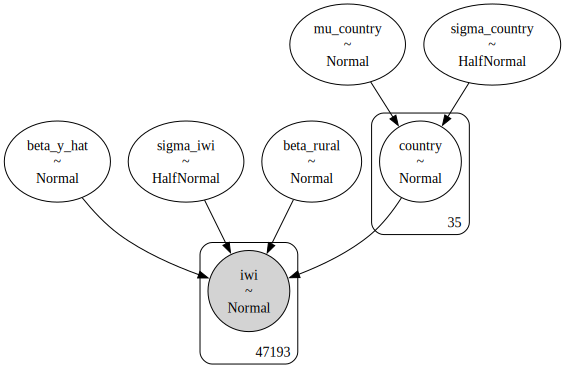

In [99]:
with model:
    # Use PyMC3's model_to_graphviz function to create a visual representation
    graph = pm.model_to_graphviz()
    display(graph)  # This will display the graph in Jupyter Notebook

In [100]:
# fit
with model:
    trace = pm.sample(draws = 500, tune=1000, chains = 4, target_accept=0.95, random_seed=109)
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu_country, sigma_country, country, beta_rural, beta_y_hat, sigma_iwi]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 199 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


DONE


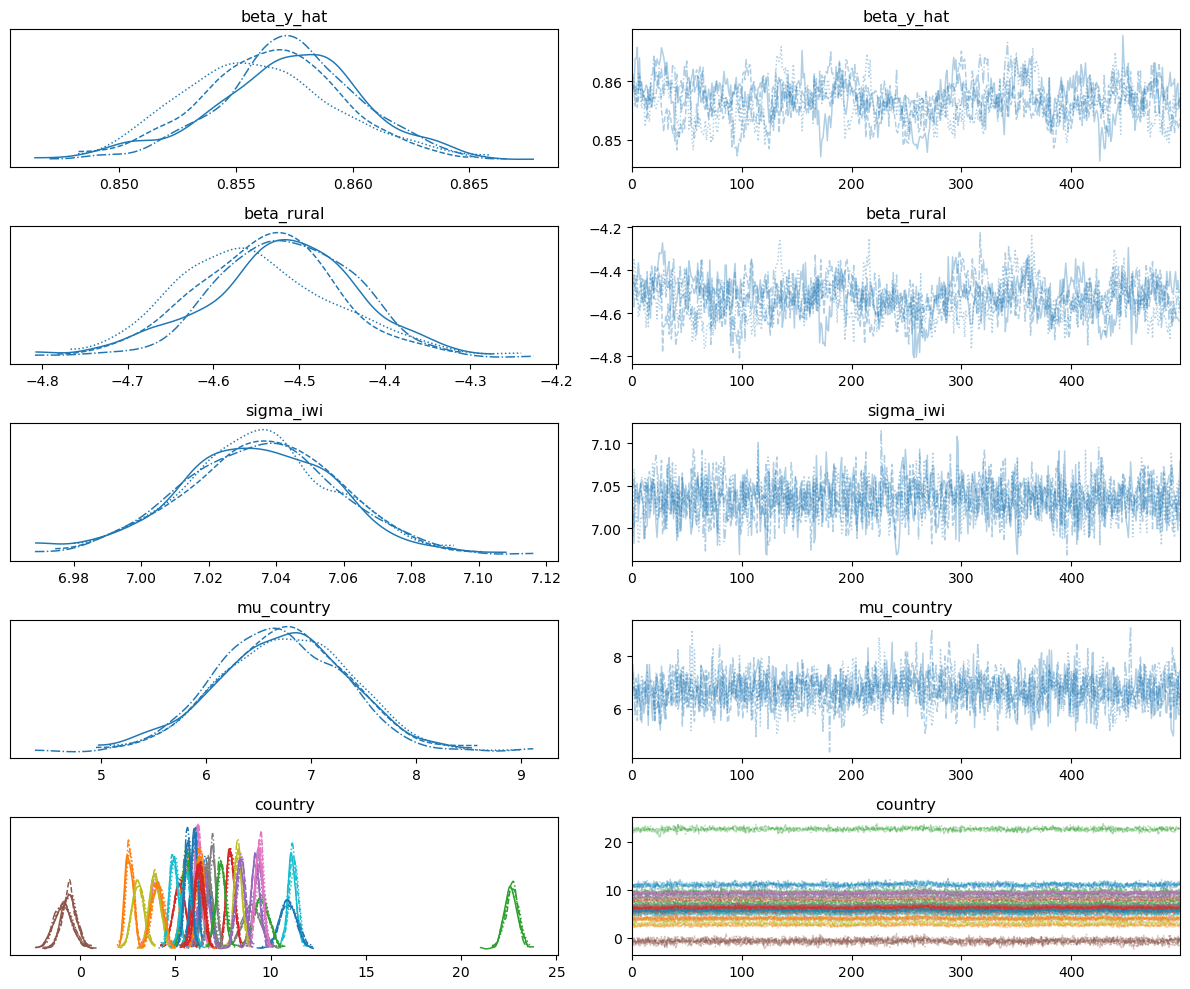

In [101]:
# examine trace plots
az.plot_trace(trace, var_names=['beta_y_hat', 'beta_rural', 'sigma_iwi', 'mu_country', 'country'])
plt.tight_layout()
plt.show()

In [109]:
code2country = {}
for i in range(df_train.shape[0]):
    code = df_train.iloc[i]['country_code']
    country = df_train.iloc[i]['country']
    code2country[code] = country

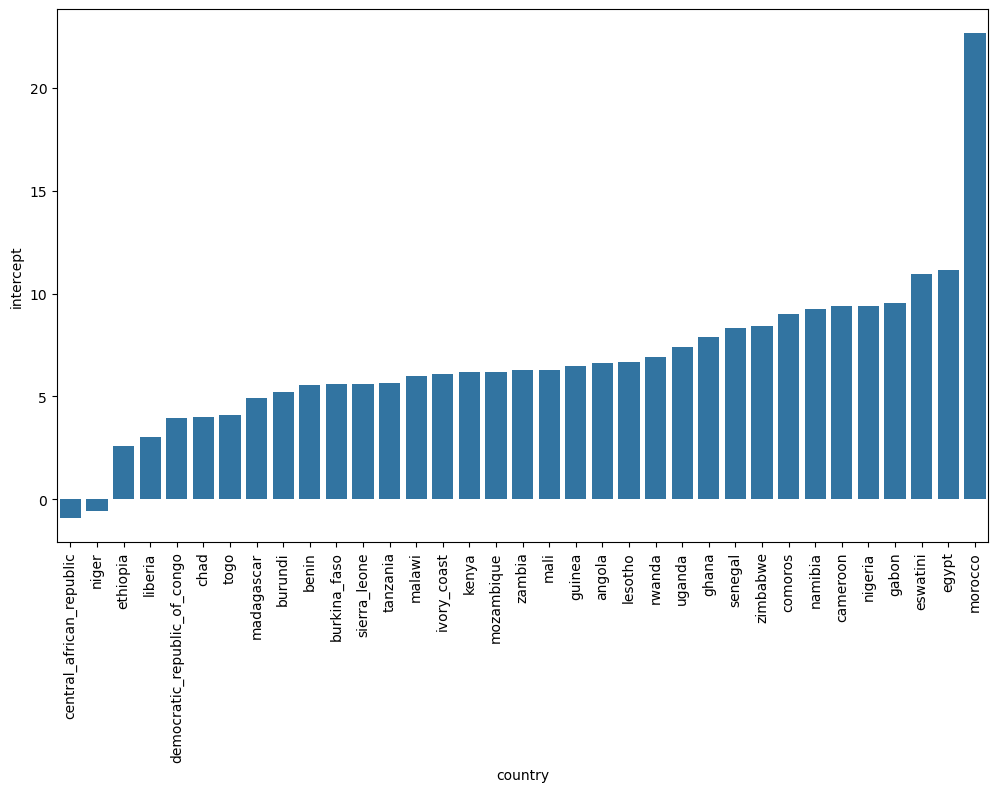

In [102]:
intercepts_means = np.mean( trace.posterior['country'].values, axis = (0, 1)) 
country_intercepts = pd.DataFrame({'country' : pd.Series(code2country.values(), index = code2country.keys()), 
                                   'intercept' : pd.Series(intercepts_means)}).sort_values(by = 'intercept')
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.tight_layout()
sns.barplot( country_intercepts, x = 'country', y = 'intercept')
plt.show()

In [104]:
# we have to through away 'south_africa' from the test set because it was not present neither in train nor validation sets
# this is the limitation of the current procedure, though, can be alliviated (discussed in the final paper)
df_test = df_test[df_test['country'] != 'south_africa']

In [110]:
def generate_predictions_from_posterior(X, trace):

    X['country_code'] = label_encoder.transform(X['country'])
    
    country_idx_new = X['country_code'].values
    
    mean_a = np.mean( trace.posterior['country'].values, axis = (0, 1)) 
    mean_beta_rural = np.mean(trace.posterior['beta_rural'].values)
    mean_beta_X = np.mean(trace.posterior['beta_y_hat'].values)
    
    predicted_y = mean_a[country_idx_new] + mean_beta_rural * X['rural'] + mean_beta_X * X['iwi_hat']

    return predicted_y

In [111]:
def caclulate_metrics(X_train, X_test, predictor, target = 'iwi'):
    
    train_preds, test_preds = predictor(X_train), predictor(X_test)
    return pd.DataFrame(data = { 
        'Correlation' : [train_preds.corr(X_train[target]), test_preds.corr(X_test[target])], 
        'R^2' : [r2_score(X_train[target], train_preds), r2_score(X_test[target], test_preds)]
    }, index = ['train', 'test'])

In [112]:
caclulate_metrics(df_train, df_test, predictor = lambda X: generate_predictions_from_posterior(X, trace))

/tmp/ipykernel_493/1507809137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['country_code'] = label_encoder.transform(X['country'])


,Correlation,R^2
train,0.934466,0.873227
test,0.851059,0.704462


In [114]:
# original metrics, without varying intercept:
print( r2_score(df_test['iwi'], df_test['iwi_hat']) )
print( df_test['iwi_hat'].corr(df_test['iwi']) )

0.6776673699035208
0.8308250078954431


/tmp/ipykernel_493/1507809137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['country_code'] = label_encoder.transform(X['country'])


Text(0, 0.5, 'Mean error drop')

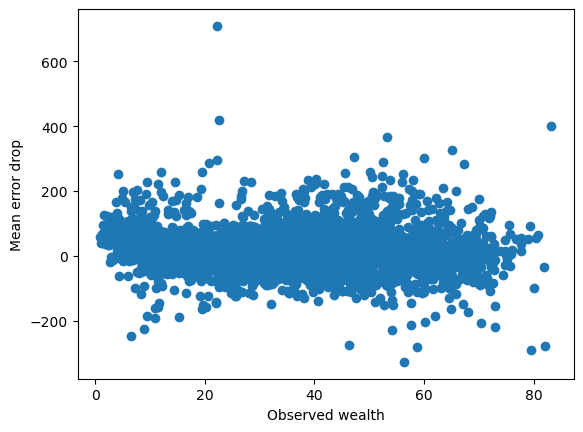

In [116]:
preds = generate_predictions_from_posterior(df_test, trace)
y_test = df_test['iwi']
baseline_preds = df_test['iwi_hat']

diff_baseline = (y_test - baseline_preds) ** 2
diff_now = (y_test - preds) ** 2
# df_test2['delta_error'] = diff_baseline - diff_now
plt.scatter(y_test, diff_baseline - diff_now)
plt.xlabel("Observed wealth")
plt.ylabel("Mean error drop")